In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport simulation
%aimport mathf
%aimport util
%aimport graph
%aimport hyper
%aimport vlgp

In [350]:
import os.path as op
import numpy as np
import scipy as sp
from scipy.special import expit
from scipy import stats
from scipy import linalg
from scipy.io import loadmat, savemat
from scipy.linalg import orth, svd
from numpy.linalg import norm
from numpy import dstack, rollaxis
from sklearn.decomposition.factor_analysis import FactorAnalysis
import h5py
import pickle

import simulation, util, graph, hyper, vlgp
from mathf import ichol_gauss, subspace
from util import rad2deg, rotate, add_constant

# plot setting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from matplotlib import colors
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import set_matplotlib_formats
import seaborn as sns

In [3]:
# Setup graphics
sns.set(font_scale=1.5)
sns.set_style("white")
samplepath = op.expanduser("~/data/sample")
outputpath = op.expanduser("~/data/output")
figurepath = op.expanduser("~/data/figure")

In [4]:
Graf_5 = h5py.File(op.join(samplepath, 'Graf_5.mat'), 'r')
ori = np.squeeze(np.array(Graf_5['ori']))
unique_ori = np.unique(ori)
y = np.array(Graf_5['y'])
# transpose y (into trial, time, neuron)
y = np.transpose(y, axes=(2, 1, 0))
# extract trials orienting at 0 and 90 deg
y0 = y[ori == 0, :, :]
y90 = y[ori == 90, :, :]

In [5]:
y4fit = np.concatenate((y0, y90), axis=0)

In [12]:
ntrial, ntime, nneuron = y4fit.shape

In [6]:
# load previous hyperparameter
vLGP_4D = loadmat(op.join(outputpath, 'Graf_vLGP_4D.mat'), squeeze_me=True)['Graf_vLGP_4D']
omega = vLGP_4D['omega'].tolist()
print(omega)

[ 0.00016897  0.00021241  0.000177    0.00013326]


In [290]:
fit_0_90_4D = loadmat(op.join(outputpath, 'Graf_5_0_90_vLGP_4D_2'), squeeze_me=True)

In [294]:
# average the latent over trials by orient
trial_per_orient = 50
latent_0 = fit_0_90_4D['mu'][:trial_per_orient, :, :]
latent_90 = fit_0_90_4D['mu'][trial_per_orient:, :, :]

In [304]:
# Subspace angle between 0 and 90 signals
print('Angle between average of 0 and average of 90 degree: {:.2f} deg'.format(rad2deg(subspace(latent_0.mean(axis=0), 
                                                                                                latent_90.mean(axis=0)))))

Angle between average of 0 and average of 90 degree: 89.72 deg


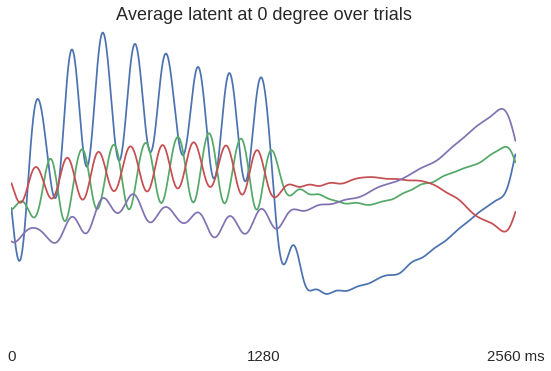

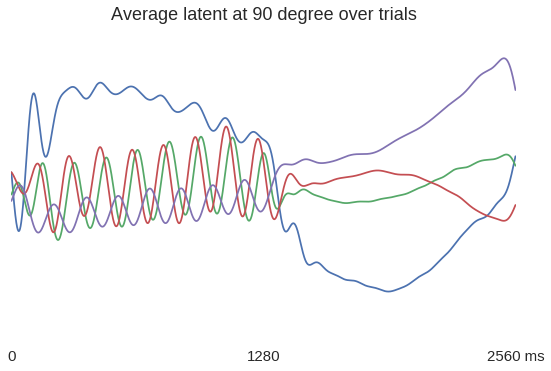

In [296]:
# plot average latent at 0 degree
plt.figure()
plt.plot(latent_0.mean(axis=(0)));
plt.xlim([0, ntime]);
plt.xticks([0, ntime // 2, ntime], ['0', '{}'.format(ntime // 2), '{} ms'.format(ntime)]);
plt.yticks([])
sns.despine(top=True, bottom=True, left=True, right=True);
plt.title('Average latent at 0 degree over trials');
plt.tight_layout()

# plot average latent at 90 degree
plt.figure()
plt.plot(latent_90.mean(axis=(0)));
plt.xlim([0, ntime]);
plt.xticks([0, ntime // 2, ntime], ['0', '{}'.format(ntime // 2), '{} ms'.format(ntime)]);
plt.yticks([])
sns.despine(top=True, bottom=True, left=True, right=True);
plt.title('Average latent at 90 degree over trials');
plt.tight_layout()

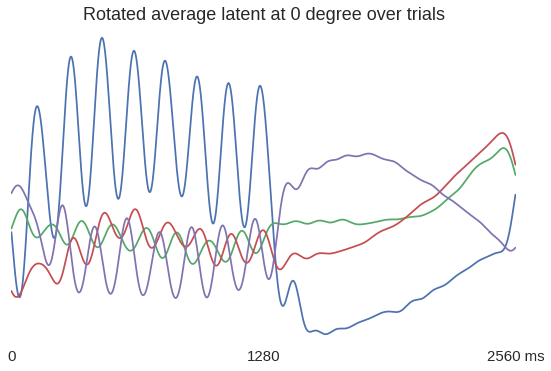

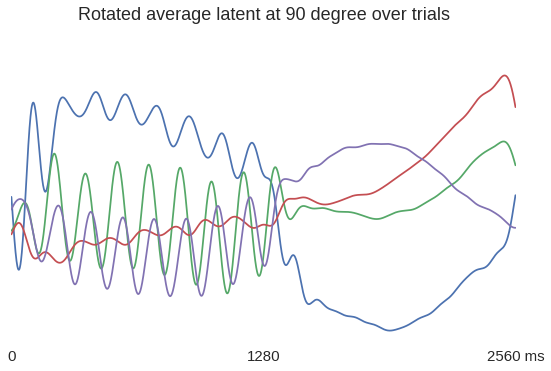

In [313]:
# SVD
latent_avg = np.concatenate((latent_0.mean(axis=(0)), latent_90.mean(axis=(0))))
u, s, v = svd(latent_avg, full_matrices=False)
rot_0 = latent_0.mean(axis=(0)).dot(v)
rot_90 = latent_90.mean(axis=(0)).dot(v)

# plot average latent at 0 degree
plt.figure()
plt.plot(rot_0);
plt.xlim([0, ntime]);
plt.xticks([0, ntime // 2, ntime], ['0', '{}'.format(ntime // 2), '{} ms'.format(ntime)]);
plt.yticks([])
sns.despine(top=True, bottom=True, left=True, right=True);
plt.title('Rotated average latent at 0 degree over trials');
plt.tight_layout()

# plot average latent at 90 degree
plt.figure()
plt.plot(rot_90);
plt.xlim([0, ntime]);
plt.xticks([0, ntime // 2, ntime], ['0', '{}'.format(ntime // 2), '{} ms'.format(ntime)]);
plt.yticks([])
sns.despine(top=True, bottom=True, left=True, right=True);
plt.title('Rotated average latent at 90 degree over trials');
plt.tight_layout()

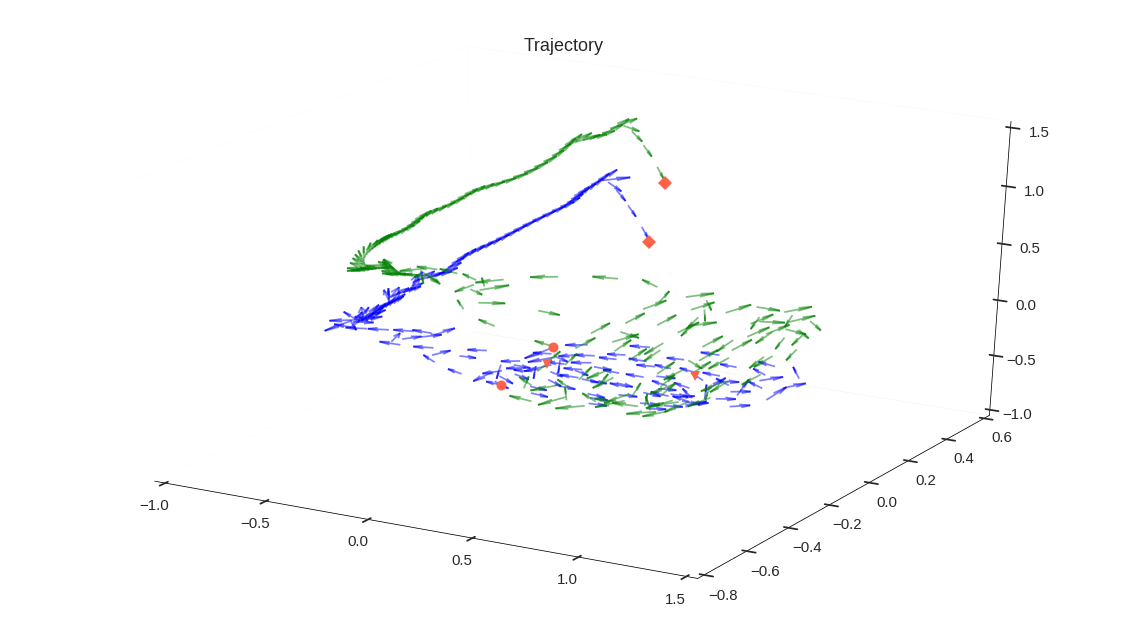

In [351]:
# plot 3D trajectory
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')
# ax.plot(latent_0[0, :, 0], latent_0[0, :, 1], latent_0[0, :, 2], lw=1, alpha=0.5);

lx = rot_0[:, 0]
ly = rot_0[:, 1]
lz = rot_0[:, 2]

u = np.diff(lx)
v = np.diff(ly)
w = np.diff(lz)

stimulus = 1280
every = 15

quiver = ax.quiver(lx[:-1][::every], ly[:-1][::every], lz[:-1][::every], u[::every], v[::every], w[::every], 
          length=0.1, pivot='tail', arrow_length_ratio=0.5, alpha=0.5, color='b')
ax.plot([lx[0]], [ly[0]], [lz[0]], ms=10, c='tomato', marker='o')
ax.plot([lx[stimulus]], [ly[stimulus]], [lz[stimulus]], ms=10, c='tomato', marker='v')
ax.plot([lx[-1]], [ly[-1]], [lz[-1]], ms=10, c='tomato', marker='D')

lx = rot_90[:, 0]
ly = rot_90[:, 1]
lz = rot_90[:, 2]

u = np.diff(lx)
v = np.diff(ly)
w = np.diff(lz)

ax.quiver(lx[:-1][::every], ly[:-1][::every], lz[:-1][::every], u[::every], v[::every], w[::every], 
          length=0.1, pivot='tail', arrow_length_ratio=0.5, alpha=0.5, color='g')
ax.plot([lx[0]], [ly[0]], [lz[0]], ms=10, c='tomato', marker='o')
ax.plot([lx[stimulus]], [ly[stimulus]], [lz[stimulus]], ms=10, c='tomato', marker='v')
ax.plot([lx[-1]], [ly[-1]], [lz[-1]], ms=10, c='tomato', marker='D')

ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# ax.view_init(60, 60)
plt.title('Trajectory')
plt.tight_layout()

In [380]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [383]:
# Animation


# Set up figure & 3D axis for animation
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
ax.axis('off')

# choose a different color for each trajectory
# colors = plt.cm.jet(np.linspace(0, 1, N_trajectories))

# set up lines and points
# lines = sum([ax.plot([], [], [], '-', c=c)
#              for c in colors], [])
# pts = sum([ax.plot([], [], [], 'o', c=c)
#            for c in colors], [])

line, = ax.plot([], [], [], '-', c='b')


# prepare the axes limits
ax.set_xlim((-1.5, 1.5))
ax.set_ylim((-1.5, 1.5))
ax.set_zlim((-1.5, 1.5))

# set point-of-view: specified by (altitude degrees, azimuth degrees)
ax.view_init(30, 0)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line.set_3d_properties([])
    return line,

# animation function.  This will be called sequentially with the frame number
def animate(i):
    # we'll step two time-steps per frame.  This leads to nice results.
#     i = (2 * i) % 2560
    x, y, z = lx[:i], ly[:i], lz[:i]
    line.set_data(x, y)
    line.set_3d_properties(z)

    ax.view_init(30, 0.3 * i)
    fig.canvas.draw()
    return line,

# for i in range(2560):
#     animate(i)

# instantiate the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=2560, interval=1, blit=True)

# Save as mp4. This requires mplayer or ffmpeg to be installed
# writer = animation.FFMpegWriter()
# anim.save(op.join(figurepath, 'lorentz_attractor.mp4'), writer=writer, fps=15, extra_args=['-vcodec', 'libx264'])

display_animation(anim)

/home/yuan/anaconda3/lib/python3.5/site-packages/matplotlib/animation.py:782: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


ValueError: Cannot save animation: no writers are available. Please install mencoder or ffmpeg to save animations.